# ANALYSIS AND DESIGN OF CLOSED LOOP SYSTEMS

This notebook discusses the relationships between transfer functions in a closed loop system
and theory-based approaches to closed loop design using transfer functions.

# Preliminaries

In [295]:
import collections
import control
import controlSBML as ctl
import lmfit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te
from IPython.display import Image

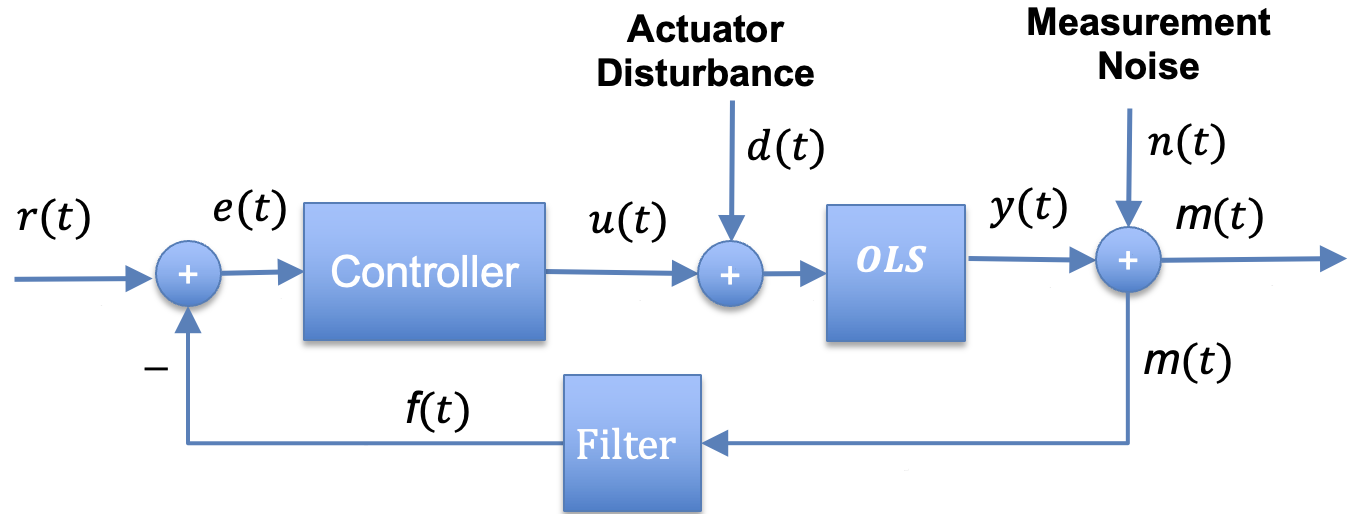

In [2]:
Image("closed_loop_system.png", width = 600, height = 300)

The starting point for transfer function analysis is to identify the system or systems to
be analyzed.
Here, we only consider single input single output (SISO) systems.
So, we need to identify which input/output relationships are of interest.

| Input  | Output | Why of interest?        | Desired DC Gain | Desired poles |
|--------|--------|-------------------------|-----------------|---------------|
| $r(t)$ | $m(t)$ | convergence to set point| 1               | very negative |
| $n(t)$ | $m(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $m(t)$ | influence of disturbance| 0               | very negative |
| $r(t)$ | $e(t)$ | convergence to set point| 0               | very negative |
| $n(t)$ | $e(t)$ | influence of noise      | 0               | very negative |
| $d(t)$ | $e(t)$ | influence of disturbance| 0               | very negative |

Some other considerations:
1. Will the OLS always be within the operating region we designed for its input?
1. What are the maximum magnitudes of $d(t)$ and $n(t)$?
1. What trade-offs can we accepts?
    1. Achieved desired DC Gain but have oscillations? 
    1. Achieved desired DC Gain but have longer settling times?

# Helpers

In [3]:
TIMES = np.linspace(0, 10, 100)

In [4]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1", "S2"], output_names=["S3"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

In [5]:
class PlotResult(object):
    def __init__(self, times = None, y_arr=None, ax=None):
        self.times = times
        self.y_arr = y_arr
        self.ax = ax
        
    def __repr__(self):
        return ""

## ``plotSys``

In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None,
            title="", ax=None, output_labels=None, figsize=None,
            ylim=None, is_legend=True, is_plot=True):
    """
    Plots the system, either a NonlinearIOSystem or a TransferFunction.
    
    Parameters
    ----------
    sys: NonlinearIOSystem or TransferFunction
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float (default is step)
    figsize: (int, int)
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    title: str (plot title)
    is_legend: bool (include legend)
    
    Returns
    -------
    PlotResut
    """
    if "NonlinearIOSystem" in str(type(sys)):
        is_nonlinear = True
    else:
        is_nonlinear = False
    if times is None:
        times = TIMES
    if forced_input is None:
        ncol = len(times)
        nrow = len(sys.input_labels)
        forced_input = np.array([np.repeat(1, nrow) for _ in range(ncol)])
        forced_input = np.reshape(forced_input, (nrow, ncol))
    if (initial_values is None) and is_nonlinear:
        initial_values = ctl.makeStateVector(sys)
    if figsize is None:
        figsize = (5, 5)
    if ax is None:
        _, ax = plt.subplots(1, figsize=figsize)
    if output_labels is None:
        if len(sys.output_labels) == 1:
            output_labels = ["y"]
        else:
            output_labels = list(sys.output_labels)
    # Simulate the system
    if is_nonlinear:
        t, y = control.input_output_response(sys, times, forced_input, initial_values)
    else:
        t, y = control.forced_response(sys, T=times, U=forced_input)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        if y.ndim == 1:
            plt.plot(t, y)
        else:
            plt.plot(t, y[0])
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    if is_legend:
        ax.legend(output_labels)
    ax.set_xlabel("time")
    ax.set_title(title)
    if ylim is not None:
        ax.set_ylim(ylim)
    if not is_plot:
        plt.close()
    return PlotResult(times=t, y_arr=y, ax=ax)
    
# Tests
times = T = np.linspace(0, 70, 500)
plot_result = plotSys(TEST_SYS, times, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr[0]))
#
numerator = 5
tf = control.TransferFunction([numerator], [1])
plot_result = plotSys(tf, times, forced_input=1, is_plot=False)
assert(len(plot_result.times) == len(plot_result.y_arr))
assert(plot_result.y_arr[0] == numerator)
print("OK!")

OK!


# Models

## Linear

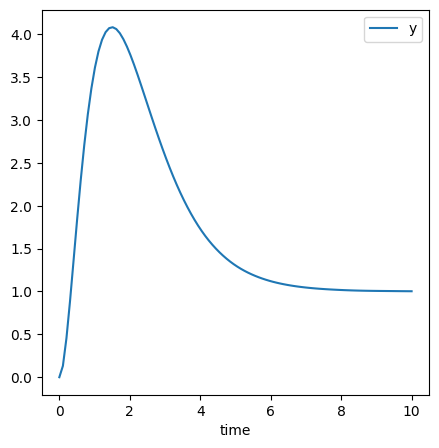

In [7]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
ctlsb = ctl.ControlSBML(LINEAR_MDL, input_names=["S1"], output_names=["S3"])
LINEAR_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="linear_sys")
_ = plotSys(LINEAR_BLDR.sys)

## Wolf

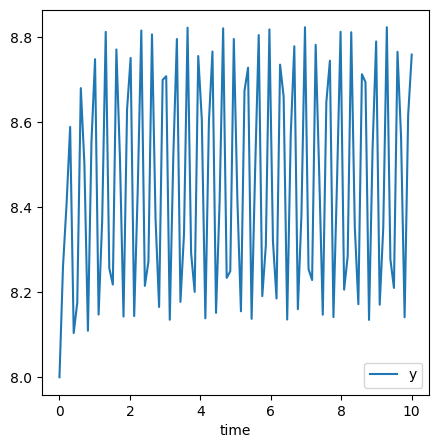

In [8]:
ctlsb = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
WOLF_BLDR = ctlsb.makeSISOTransferFunctionBuilder(system_name="wolf_sys")
_ = plotSys(WOLF_BLDR.sys)

In [9]:
print(ctlsb.antimony)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Noise Transfer Function

## Terminology

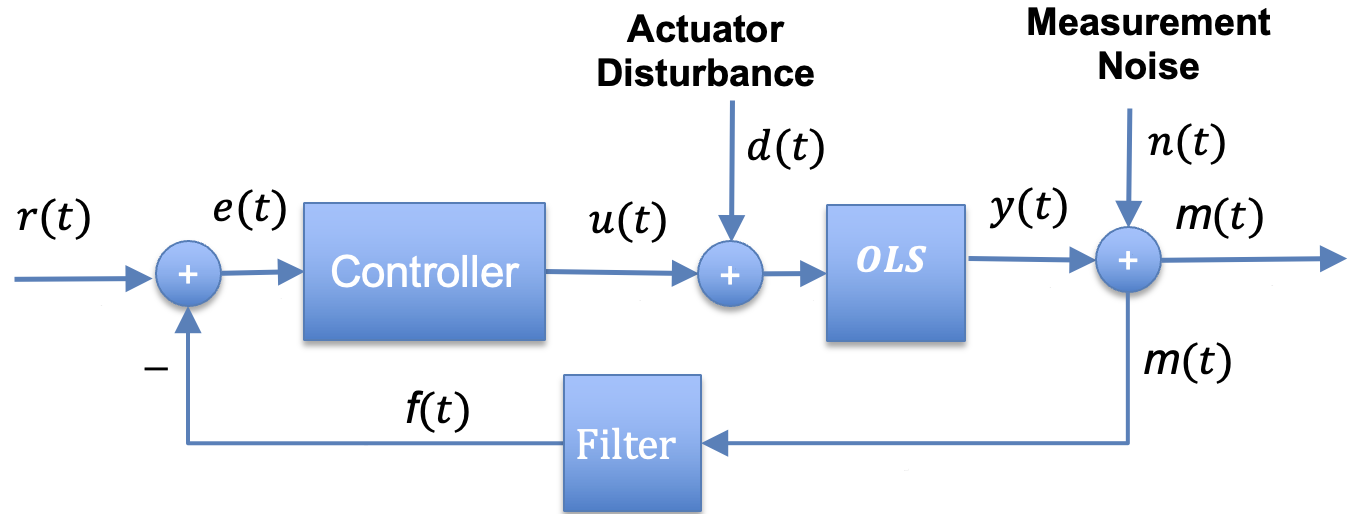

In [10]:
Image("closed_loop_system.png", width = 300, height = 150)

Define the transfer functions:
* $G_C (s)$: controller
* $G_F (s)$: filter
* $G_O (s)$: open loop system

Define the signals
* $R(s)$: reference input (set point)
* $D(S)$: disturbance
* $N(s)$: noise

## Steps for constructing a transfer function from existing system elements
1. Write equations that contain the input and output signals.
1. Construct a single equation that contains only the input and output.
1. Solve for the transfer function.

## Transfer function derivation

Find the transfer function from $n(t)$ to $m(t)$.
That is, $G_{NM} = \frac{M(s)}{N(s)}$.

This transfer function assumes
that $r(t) = 0 = d(t)$.

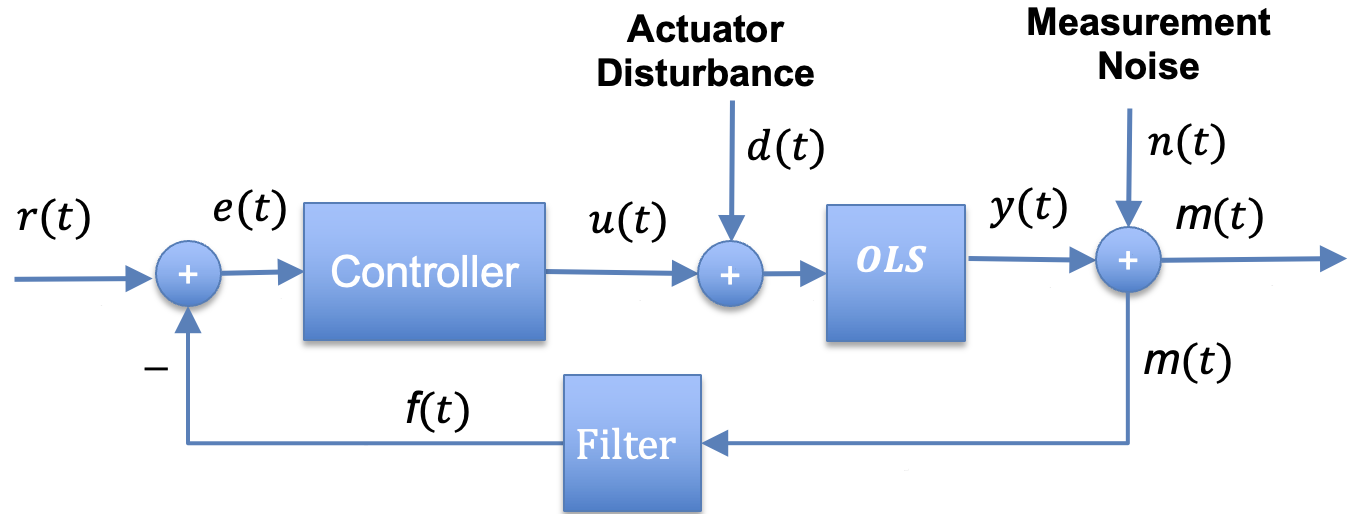

In [11]:
Image("closed_loop_system.png", width = 300, height = 150)

This simplifies to

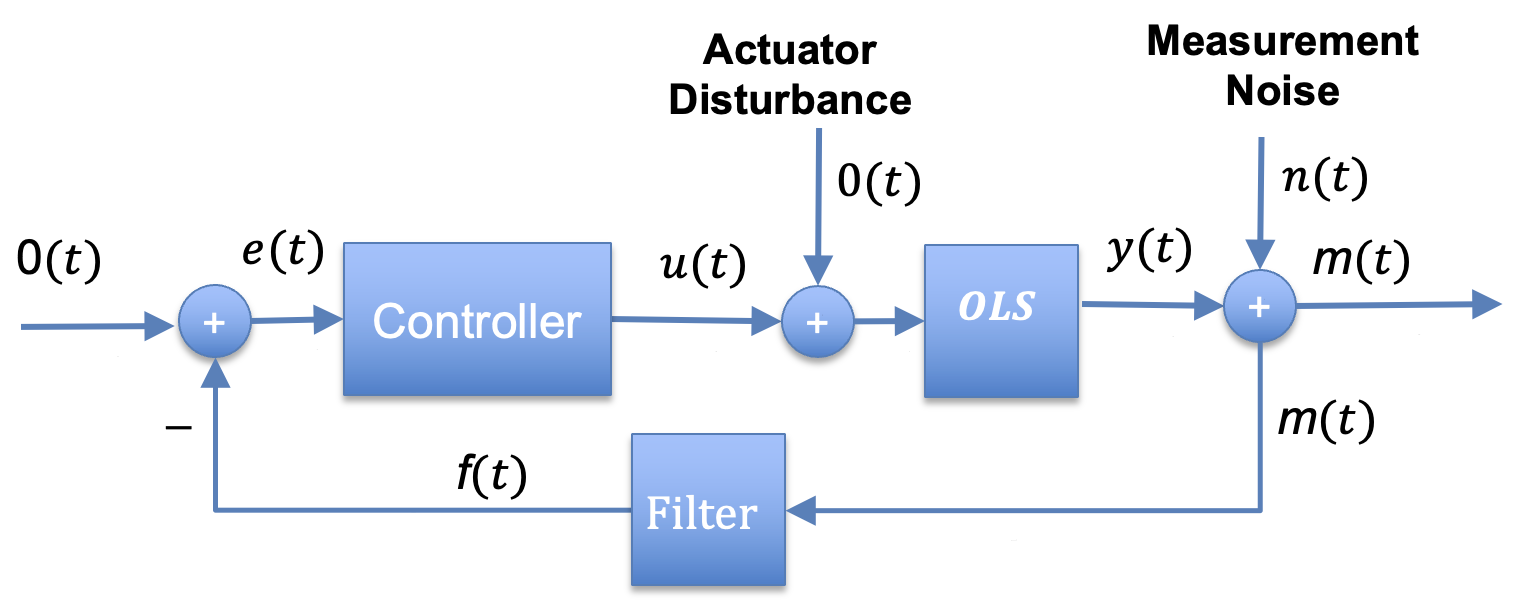

In [12]:
Image("simplified_noise_closed_loop_system.png", width = 300, height = 150)

### 1. Write the equations that contain the input and output signal

1. $M(s) = E(s) G_C (s) G_O(s) + N(s)$
1. $E(s) = - M(s) G_F(s)$

### 2. Construct a single equation that contains only the input and output

Substituting the second equation into the first:

\begin{eqnarray}
M(s) & = & E(s) G_C (s) G_O(s) + N(s) \\
M(s)&  =& - M(s) G_F(s) G_C (s) G_O(s) + N(s) \\
M(s) ( 1 + G_C (s) G_O (s) G_F (s) )&  = & N(s) \\
\end{eqnarray}

### 3. Solve for the transfer function


\begin{eqnarray}
G_{NM} (s) & = & \frac{M(s)}{N(s)} \\
& = & \frac{ 1 }{1 + G_C (s) G_O(s) G_F(s)} \\
\end{eqnarray}

In [13]:
## Comparison with $G_{RM}$

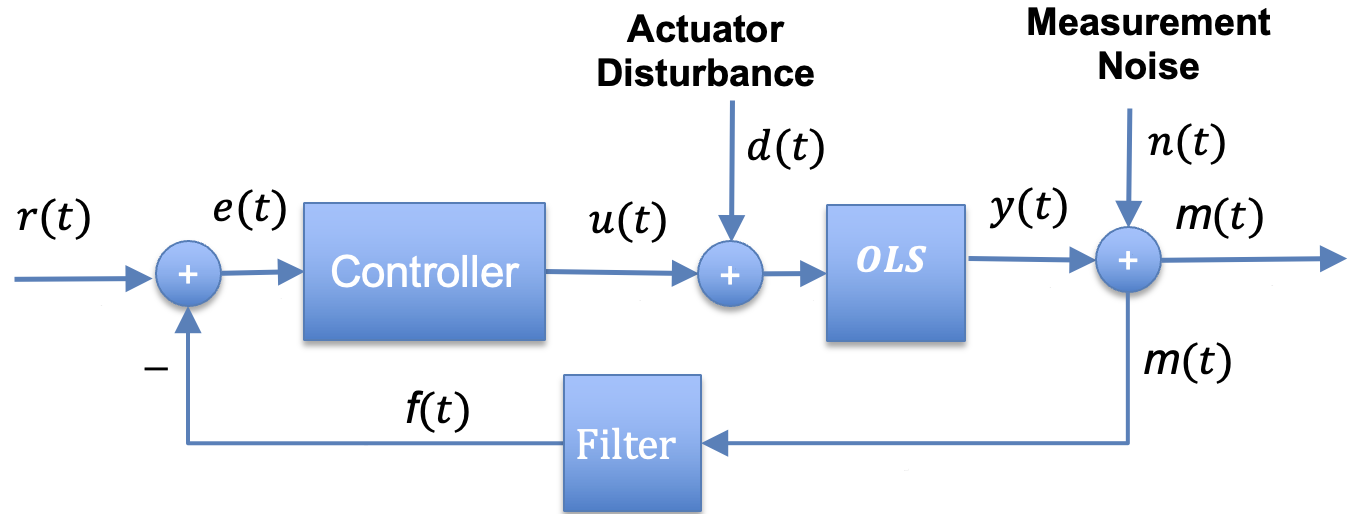

In [14]:
Image("closed_loop_system.png", width = 300, height = 150)

\begin{eqnarray}
G_{RM} (s) & = & \frac{ G_C (s) G_O(s) }{1 + G_C (s) G_O(s) G_F(s)}\\
\end{eqnarray}

If $G_F(0) = 1$ and $G_{RM} (0) = 1$, then what is $G_{NM} (0)$?

These assumptions mean that
\begin{eqnarray}
G_{RM} (0)  & = & \frac{ G_C (0) G_O(0) }{1 + G_C (0) G_O(0)}\\
& = & 1 - \frac{ 1 }{1 + G_C (0) G_O(0)}\\
& = & 1 - G_{NM} (0)\\
\end{eqnarray}

So, if $G_{RM} = 1$, then $G_{RN} = 0$.

Note that $G_{RM}$ has the same poles as $G_{NM}$.

**Justification**

Let $G_x (s) = \frac{N_x(s)}{D_x (s)}$, where $N_x(s)$ and $D_x(s)$ are polynomials in $s$.
\begin{eqnarray}
G_{RM} (s)  & = & \frac{ G_C (s) G_O(s) }{1 + G_F (s) G_C (s) G_O(s)}\\
& = & \frac { N_C (s)/D_C (s) N_O(s) / D_O(s) }{1 + N_F(s)/D_F(s) N_C (s)/D_C(s) N_O(s)/D_O(s)}\\
& = & \frac {  D_F(s) N_C (s) (s) N_O(s)) }{D_F(s) D_C(s) D_O(s) + N_F(s) N_C (s) N_O(s)}\\
\end{eqnarray}

\begin{eqnarray}
G_{NM} (s)  & = & \frac{ 1 }{1 + G_F (s) G_C (s) G_O(s)}\\
& = & \frac { 1 }{1 + N_F(s)/D_F(s) N_C (s)/D_C(s) N_O(s)/D_O(s)}\\
& = & \frac { D_F(s) D_C (s) D_O(s) }{D_F(s) D_C(s) D_O(s) + N_F(s) N_C (s) N_O(s)}\\
\end{eqnarray}

# Theory-based Closed Loop Design

It suffices to consider $G_{RM}$ for control design with the objectives:
1. The dominant pole is sufficiently negative and has a sufficient small imaginary part.
1. The system is resilient to measurement noise.
1. $G_{RM}$ has a DC Gain is 1.

If we use $I$ control, then we automatically get a DC Gain of 1.

Resilience to noise means that $k_F$ is sufficiently small so that the filtered output
does not have oscillations.

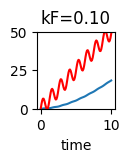

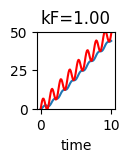

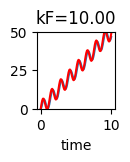

In [15]:
# Effect of the filter parameter on a linear increasing sine wave
forced_input = 5*np.sin(5*TIMES) + 5*TIMES # Linear increase
for kF in [0.1, 1, 10]:
    tf = control.TransferFunction([kF], [1, kF])
    plot_result = plotSys(tf, forced_input=forced_input, times=TIMES, figsize=(1,1), ylim=[0, 50],
           title="kF=%2.2f" % kF, is_legend=False)
    plot_result.ax.plot(TIMES, forced_input, color="red")

We see that $y(t)$ is smoother for small values of $k_F$, and $y(t)$ better approximates the signal trend (i.e., line slope) if $k_F$ is larger.

## Design problem for PI Control

Find $k_P$, $k_I$, $k_F$ such that:
1. The dominant pole is sufficiently negative and has a sufficient small imaginary part.
1. $k_F$ is sufficiently (positive) small.

This can be phrased as a constained optimization.

Minimize (make more negative) the dominant pole of $G_{RM}$ such that:
1. The absolute value of the imaginary part of the dominant pole is less than $I_{max}$.
1. $k_F \leq F_{MAX}$

# Constrained Optimization in Python

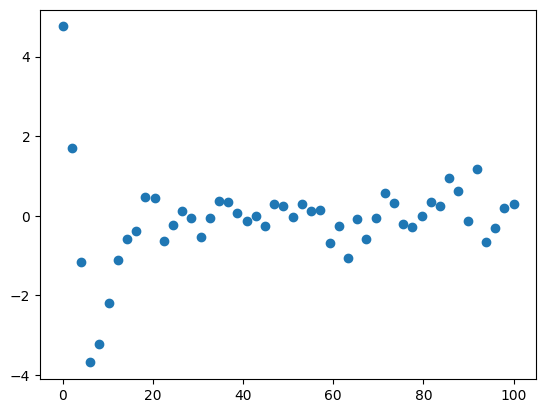

In [16]:
# Data generation
XVALUES = np.linspace(0, 100)
noise = np.random.normal(size=XVALUES.size, scale=0.5)
DATA = 7.5 * np.sin(XVALUES*0.22 + 2.5) * np.exp(-XVALUES*XVALUES*0.01) + noise
plt.scatter(XVALUES, DATA)

In [17]:
def makePredict():
    """
    Constructs a function that predicts the output from parameters and the input.
    
    Returns
    -------
    Function
      arguments: lmfit.Parameters, array-float
      returns: array-float
    """
    def predict(params, xv):
        """
    
        Parameters
        ----------
        params: lmfit.Parameters
        xv: array-float

        Returns
        -------
        array-float
        """
        amp = params['amp']
        phaseshift = params['phase']
        freq = params['frequency']
        decay = params['decay']
        predictions = amp * np.sin(xv*freq + phaseshift) * np.exp(-xv*xv*decay)
        return predictions
    return predict


def calculateResidual(params, xv, data):
    """
    Calculates the residuals for a prediction.
    
    Parameters
    ----------
    params: lmfit.Parameters
    xv: array-float
    data: array-float (observed values)
    
    Returns
    -------
    array-float (residuals)
    """
    predict = makePredict()
    predictions = predict(params, xv)
    return data - predictions


params = lmfit.Parameters()
params.add('amp', value=10)
params.add('decay', value=0.007)
params.add('phase', value=0.2)
params.add('frequency', value=3.0)

out = lmfit.minimize(calculateResidual, params, args=(XVALUES, DATA))
PARAMS = out.params
PARAMS

name,value,standard error,relative error,initial value,min,max,vary
amp,7.30856675,1.43312522,(19.61%),10,-inf,inf,True
decay,0.01083141,0.00254854,(23.53%),0.007,-inf,inf,True
phase,0.72597723,0.14798393,(20.38%),0.2,-inf,inf,True
frequency,2.84203713,0.04055294,(1.43%),3.0,-inf,inf,True


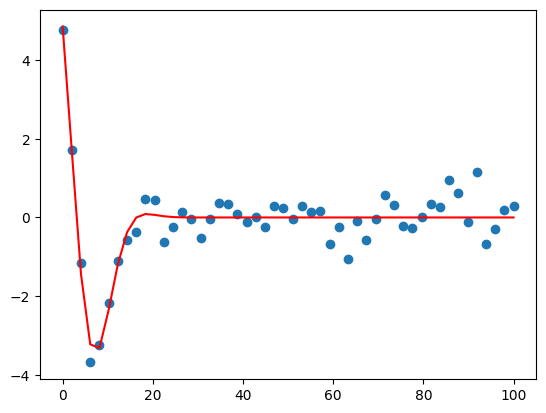

In [18]:
plt.scatter(XVALUES, DATA)
predict = makePredict()
plt.plot(XVALUES, predict(PARAMS, XVALUES), color="red")

## Cheat sheet for using ``lmfit``

1. Generate fitting data (``DATA``)
1. Write a function "factory" that creates a candidate function to fit the data
1. Write ``calculateResiduals`` that calls the function factory to calculate residuals between ``DATA`` and the candidate function
1. Construct the parameters for ``lmfit.Parameters``
1. Run ``lmfit.minimize``

# Control Design Using Constrained Optimization

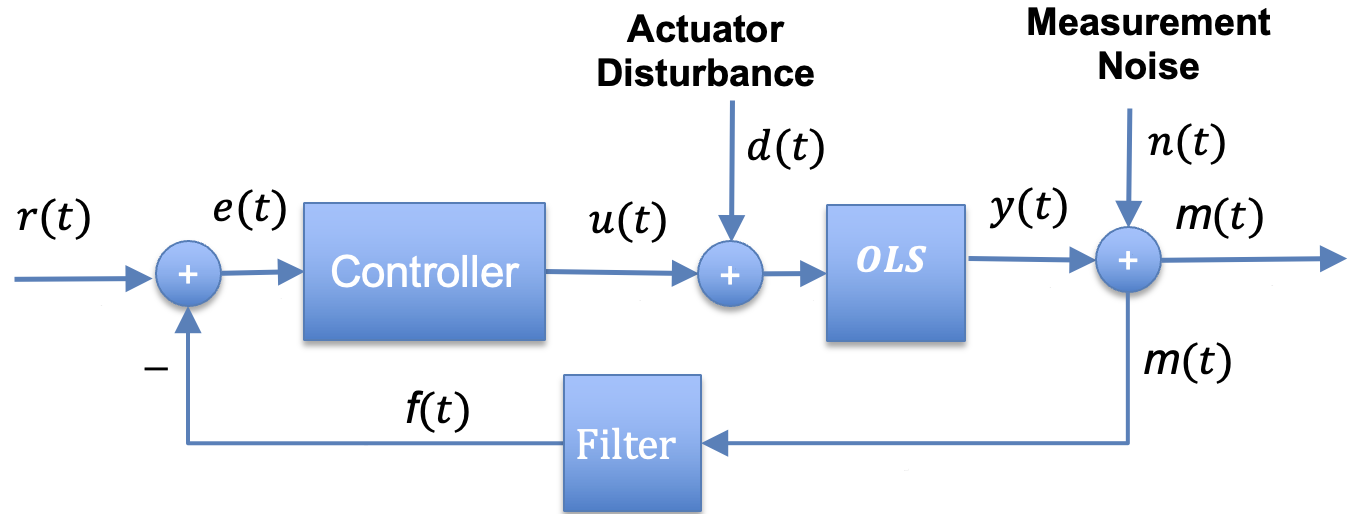

In [19]:
Image("closed_loop_system.png", width = 400, height = 200)

## Problem statement

Given a transfer function for the OLS, construct a closed loop system with a PI controller and a filter.

The constained optimization finds
$k_P$, $k_I$, $k_F$ such that:
1. The dominant pole is sufficiently negative and has a sufficient small imaginary part.
1. $k_F$ is sufficiently (positive) small.

This will be implemented using ``lmfit`` constrained optimization.

In [120]:
gO_tf = value=control.TransferFunction([1], [1, 2])

## Step 1. Candidate closed loop transfer function

A candidate design for a closed loop system results in a new transfer function
for the closed loop system.
So, we need a way to construction a *transfer function*
for a new design. In software, this is called a factory. The factory inputs $k_P$, $k_I$, $k_F$.
To make it more general, we include $G_O(s)$, the open loop transfer function.
The output is the closed loop transfer function $G_{RM} (s)$.

In [294]:
def makeCLTransferFunctions(gO_tf, params):
    """
    Makes two closed loop transfer functions.
        G_RM (s) - transfer function from the reference input to the measurement output
        G_NM (s) - transfer function from the noise input to the measurement output
    
    Parameters
    ----------
    gO_tf: control.TransferFunction (open loop transfer function)
    params:
        kP: float
        kI: float
        kF: float (a value <= 0 indicates there is no filter)
    
    Returns
    -------
    control.TransferFunction, control.TransferFunction
    """
    # Extract the parameters
    kP = params["kP"].value
    kI = params["kI"].value
    kF = params["kF"].value # a value of 0 indicates that there is no filter
    # Construct PI Controller
    gC_tf = control.TransferFunction([kP], [1]) + control.TransferFunction([kI], [1, 0])
    # Construct Filter
    if kF > 0:
        gF_tf = control.TransferFunction([kF], [1, kF])
    else:
        gF_tf = control.TransferFunction([1], [1])
    # RM Closed loop Transfer function
    gRM_tf = control.feedback(gC_tf*gO_tf, gF_tf)
    # NM Closed loop Transfer function
    gNM_tf = control.feedback(1, sys2=gC_tf*gO_tf*gF_tf)
    
    #
    return gRM_tf, gNM_tf
#
is_plot = False
gO_tf = value=control.TransferFunction([1], [1, 1])
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=1)
params.add("kF", value=1)
gRM_tf, gNM_tf = makeCLTransferFunctions(gO_tf, params)
assert(isinstance(gRM_tf, control.TransferFunction))
assert(isinstance(gNM_tf, control.TransferFunction))
plot_response = plotSys(gRM_tf, is_plot=is_plot)
plot_response = plotSys(gNM_tf, is_plot=is_plot)
#
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=1)
params.add("kF", value=-1)
gRM_tf, gNM_tf = makeCLTransferFunctions(gO_tf, params)
assert(isinstance(gRM_tf, control.TransferFunction))
assert(isinstance(gNM_tf, control.TransferFunction))
plot_response = plotSys(gRM_tf, is_plot=is_plot)
plot_response = plotSys(gNM_tf, is_plot=is_plot)
print("OK!")

OK!


## Step 2. Calculate residuals

The key challenge here is what residuals are we computing. At first glance, there is no
observational data to compare against.
However, on second thought, there are two sets of observational data.
The first is an ideal unit step response, which is just a unit step.
The second is an ideal noise response, which is a constant at zero.
The first is the ideal response for $G_{RM} (s)$ to a step in $R(s)$.
The second is the ideal response for $G_{NM} (s)$ to noise input.

In [259]:
def calculateDesignResiduals(params, weight=0.1):
    """
    Calculates the residuals with an ideal step response.
    
    Parameters
    ----------
    params: lmfit.Parameters
    
    Returns
    -------
    array-float
    """
    gRM_tf, gNM_tf = makeCLTransferFunctions(gO_tf, params)
    times = np.linspace(0, 10, 100)
    # Calculate residuals for a step response
    _, yv_est = control.forced_response(gRM_tf, T=times, U=1)
    yv_ideal = np.repeat(1, len(times)) # Unit step
    step_residuals = yv_ideal - yv_est
    # Calculate residuals for a sinusoidal noise input
    inputs = amp*np.sin(5*times) # Sinusoid input
    times, yv_est = control.forced_response(gNM_tf, T=times, U=inputs)
    yv_ideal = np.repeat(0, len(times))
    sinusoid_residuals = yv_ideal - yv_est
    #
    return step_residuals + sinusoid_residuals

# Tests
params = lmfit.Parameters()
params.add("kP", value=1)
params.add("kI", value=0)
params.add("kF", value=0)
residuals = calculateDesignResiduals(params)
assert(np.sum(residuals) > 0)
print("OK!")

OK!


## Step 3. Do the optimization

In [284]:
params = lmfit.Parameters()
params.add("kP", value=1, min=0, max=1e3)
params.add("kI", value=1, min=0, max=1e3)
params.add("kF", value=1, min=0, max=1e6)

out = lmfit.minimize(calculateDesignResiduals, params)
out.params

name,value,standard error,relative error,initial value,min,max,vary
kP,999.999999,3281.19928,(328.12%),1,0.00000000,1000.00000,True
kI,999.996725,99174.6795,(9917.50%),1,0.00000000,1000.00000,True
kF,45196.0530,4.6805e+10,(103558859.09%),1,0.00000000,1000000.00,True


In [285]:
gRM_tf, gNM_tf = makeCLTransferFunctions(gO_tf, out.params)
gRM_tf.poles()

array([-4.41728666e+04+0.j, -1.02418740e+03+0.j, -9.98996749e-01+0.j])

[-4.41728666e+04+0.j -1.02418740e+03+0.j -9.98996749e-01+0.j]


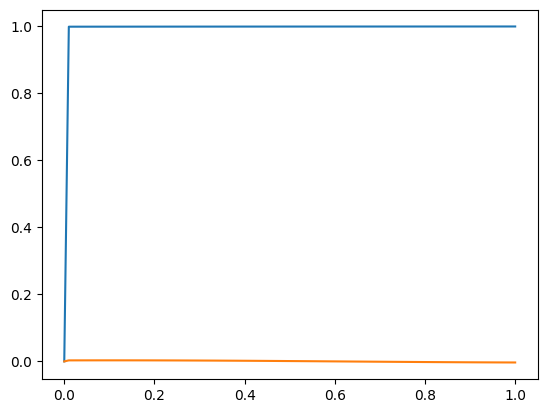

In [292]:

times = np.linspace(0,1, 100)
_, yv = control.forced_response(gRM_tf, T=times, U=1)
plt.plot(times, yv)
_, yv = control.forced_response(gNM_tf, T=times, U=np.sin(3*times))
print(gRM_tf.poles())
plt.plot(times, yv)

In [401]:
def designClosedLoop(gO_tf, is_filter=True, amp=1, kmax=1e4):
    """
    Finds parameters for the closed loop system that eliminate noise and have a good step response.
    
    Paramters
    ---------
    g0_tf: control.TransferFunction (OLS transfer function)
    is_filter: bool (include the filter)
    amp: 0 <=float  (amplitude of the sine wave used to evaluate noise response)
    kmax: float (maximum value of a constant)
    
    Returns
    -------
    DesignResult
    control.TransferFunction, control.TransferFunction (gRM_tf, gNM_tf)
    """
    # grm: gRM_tf
    # gnm: gNM_tf
    # params: fitted parameters
    # det: minimizer_result
    DesignResult = collections.namedtuple("DesignResult",
          "grm gnm params det")
    
    def calculateDesignResiduals(params):
        """
        Calculates the residuals with an ideal step response.

        Parameters
        ----------
        params: lmfit.Parameters

        Returns
        -------
        array-float
        """
        gRM_tf, gNM_tf = makeCLTransferFunctions(gO_tf, params)
        times = np.linspace(0, 10, 100)
        # Calculate residuals for a step response
        _, yv_est = control.forced_response(gRM_tf, T=times, U=1)
        yv_ideal = np.repeat(1, len(times)) # Unit step
        step_residuals = yv_ideal - yv_est
        # Calculate residuals for a sinusoidal noise input
        inputs = amp*np.sin(5*times) # Sinusoid input
        times, yv_est = control.forced_response(gNM_tf, T=times, U=inputs)
        yv_ideal = np.repeat(0, len(times))
        sinusoid_residuals = yv_ideal - yv_est
        #
        return step_residuals + sinusoid_residuals
    # 
    params = lmfit.Parameters()
    params.add("kP", value=1, min=0, max=kmax)
    params.add("kI", value=1, min=0, max=kmax)
    params.add("kF", value=1, min=0, max=kmax)
    minimizer_result = lmfit.minimize(calculateDesignResiduals, params)
    new_params = minimizer_result.params
    #
    gRM_tf, gNM_tf = makeCLTransferFunctions(gO_tf, new_params)
    design_result = DesignResult(grm=gRM_tf, gnm=gNM_tf, params=new_params, det=minimizer_result)
    return design_result

# Tests
design_result = designClosedLoop(gO_tf, kmax=1e6, amp=10)
design_result.grm

TransferFunction(array([4.43589604e+03, 1.24778793e+06, 7.83663218e+07]), array([1.00000000e+00, 1.87636675e+02, 8.28087525e+05, 7.83663218e+07]))

In [402]:
design_result.params

name,value,standard error,relative error,initial value,min,max,vary
kP,4435.89604,714402.604,(16105.03%),1,0.00000000,1000000.00,True
kI,419887.044,44570523.1,(10614.88%),1,0.00000000,1000000.00,True
kF,186.636675,30899.3992,(16555.91%),1,0.00000000,1000000.00,True


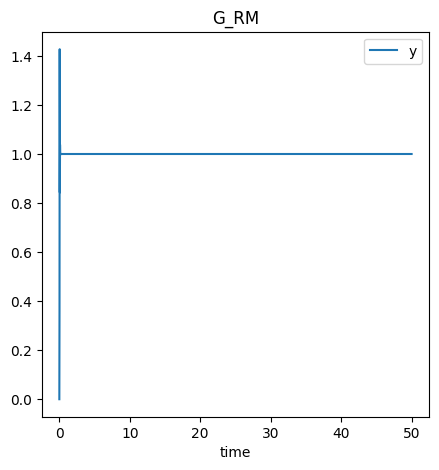

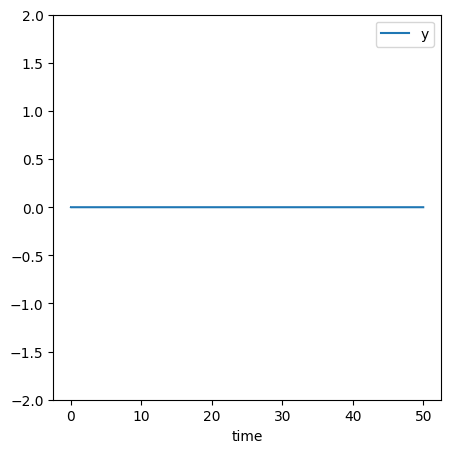

In [400]:
times = np.linspace(0, 50, 2000)
plotSys(design_result.grm, title="G_RM", times=times)
plotSys(design_result.gnm, forced_input=np.sin(3*times), ylim=[-2, 2], times=times)

# Checking the Operating Range

**Issues**
1. Should extinguish noise if $k_F$ is small, not large.